# Fine Tuning YOLO on a Custom Dataset
This notebook creates a custom dataset of randomly sized and colored circles and triangles along with an annotation file formatted for YOLO. It then uses that data to perform fine tuning on one of the pre-trained models and displays the results.

First let's import all the libraries we'll need for the notebook.

In [1]:
import cv2
import numpy as np
import os
import shutil 
from IPython.display import Image, display, Code
import matplotlib.pyplot as plt
from ultralytics import YOLO
import supervision as sv
%matplotlib inline

## Create the Dataset
Create a dataset of randomly sized and colored circles and triangles.

In [2]:
# Specify a root location for the dataset
DATA_DIR = "./datasets"

# Specify the hight and width of the images in the dataset (640 is the default YOLO size)
(IMG_WIDTH, IMG_HEIGHT) = (640, 640)

In [3]:
def delete_dirs(dirs=[]):
    """Deletes a list of directories

    Args:
        dirs (list, optional): The directories to delete. Defaults to [].
    """

    for dir in dirs:
        if os.path.exists(dir):
            shutil.rmtree(dir) 

# Delete folders generated during previous training cycles
delete_dirs(['runs/detect', f'{DATA_DIR}/test', f'{DATA_DIR}/train', f'{DATA_DIR}/val'])

In [4]:
def get_yolo_annotations(x1, y1, x2, y2, image_width, image_height):
    """Convert bounding box annotations to YOLO annotations that are resilient to image resizing.

    Args:
        x1 (int): The pixel coordinate for the left hand side of the bounding box
        y1 (int): The pixel coordinate for the top of the bounding box
        x2 (int): The pixel coordinate for the right hand side of the bounding box
        y2 (int): The pixel coordinate for the bottom of the bounding box
        image_width (int): The width of the image
        image_height (int): The height of the image

    Returns:
        center_x (float): The distance of the bounding box's center from the left side of the image. Expressed in the range of 0.0 to 1.0.
        center_y (float): The distance of the bounding box's center from the top of the image. Expressed in the range of 0.0 to 1.0.
        width (float):    The percentage of the image's width that the bounding box occupies. Expressed in the range of 0.0 to 1.0.
        height (float):   The percentage of the image's height that the bounding box occupies. Expressed in the range of 0.0 to 1.0.
    """

    center_x = (x2+x1)/2/image_width
    center_y = (y2+y1)/2/image_height
    width    = (x2-x1)/image_width
    height   = (y2-y1)/image_height
    
    return center_x, center_y, width, height

In [5]:
def write_yolo_annotations(x1, y1, x2, y2, image_width, image_height, class_id, label_file):
    """Convert the bounding box annotations to YOLO format and write to a file.

    Args:
        x1 (int): The pixel coordinate for the left hand side of the bounding box
        y1 (int): The pixel coordinate for the top of the bounding box
        x2 (int): The pixel coordinate for the right hand side of the bounding box
        y2 (int): The pixel coordinate for the bottom of the bounding box
        image_width (int): The width of the image
        image_height (int): The height of the image
        class_id (int): A unique integer associated with the class
        label_file (string): The file location to write the annotations
    """
    
    # Get YOLO annotations
    center_x, center_y, width, height = get_yolo_annotations(x1, y1, x2, y2, image_width, image_height)

    # Make sure values are reasonable
    if center_x > 0 and center_y > 0 and width > 0 and height > 0 and \
       center_x <= 1 and center_y <= 1 and width <= 1 and height <= 1:
        
        # Write the annotations
        f = open(label_file, 'a')
        f.write('{} {} {} {} {}\n'.format(class_id, center_x, center_y, width, height))
        f.close()
    else:
        print(f"At least a portion of the class is outside the image boundary ({center_x}, {center_y}, {width}, {height})")

In [6]:
def draw_random_circle(img):
    """Draws a randomly sized and colored circle on an image

    Args:
        img (array): The image to modify

    Returns:
        center_x (int): The x coordinate for the center of the circle
        center_y (int): The y coordinate for the center of the circle
        radius (int): The radius of the circle
    """
    
    radius   = np.random.randint(10, 100)
    center_x = np.random.randint(radius, IMG_WIDTH-radius)
    center_y = np.random.randint(radius, IMG_HEIGHT-radius)
    color    = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    
    cv2.circle(img, (center_x, center_y), radius, color, -1)

    return center_x, center_y, radius

In [7]:
def draw_random_triangle(img):
    """Draws a randomly sized and colored triangle on an image

    Args:
        img (array): The image to modify

    Returns:
        lhs (int): The x coordinate for the center of the circle
        rhs (int): The y coordinate for the center of the circle
        top (int): The radius of the circle
        bottom (int) :
    """

    # get a random point in the image at least 100 pixels from the border
    pt1 = (np.random.randint(100, IMG_WIDTH-100), np.random.randint(100, IMG_HEIGHT-100))
    # get a second point 50 to 100 pixels from the first point 
    pt2 = (pt1[0]+np.random.randint(50, 100), pt1[1]+np.random.randint(50, 100))
    # get a third point 50 to 100 pixels from the first point
    pt3 = (pt1[0]-np.random.randint(50, 100), pt1[1]+np.random.randint(50, 100))

    triangle = np.array( [pt1, pt2, pt3] )

    color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    
    cv2.drawContours(img, [triangle], 0, color, -1)

    x_vals = [x[0] for x in triangle]
    y_vals = [x[1] for x in triangle]

    lhs = np.min(x_vals)
    rhs = np.max(x_vals)
    top = np.min(y_vals)
    bottom = np.max(y_vals)

    return lhs, rhs, top, bottom

In [8]:
CIRCLE_CLASS_ID   = 0
TRIANGLE_CLASS_ID = 1

def create_data(dir, num_images):
    """Populates a directory with a dataset

    Args:
        dir (string): The root directory of the dataset
        num_images (ing): The number of images in the dataset
    """
    
    img_dir   = os.path.join(DATA_DIR, dir, "images")
    label_dir = os.path.join(DATA_DIR, dir, "labels")
    os.makedirs(img_dir,   exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    for i in range(num_images):
        img = np.random.randint(0, 255, (IMG_HEIGHT, IMG_WIDTH, 3), "uint8")
        img_file   = "{}/{}.jpg".format(img_dir,   i)
        label_file = "{}/{}.txt".format(label_dir, i)

        center_x, center_y, radius = draw_random_circle(img)
        write_yolo_annotations(center_x-radius, center_y-radius, center_x+radius, center_y+radius, IMG_WIDTH, IMG_HEIGHT, CIRCLE_CLASS_ID, label_file)

        x_min, x_max, y_min, y_max = draw_random_triangle(img)
        write_yolo_annotations(x_min, y_min, x_max, y_max, IMG_WIDTH, IMG_HEIGHT, TRIANGLE_CLASS_ID, label_file)

        cv2.imwrite(img_file, img)

Let's use these methods we just created to make our dataset.

In [9]:
create_data("train", 150)
create_data("test" ,  25)
create_data("val"  ,   9)

Let's print out one of our validation images and annotations to make sure everything looks good.

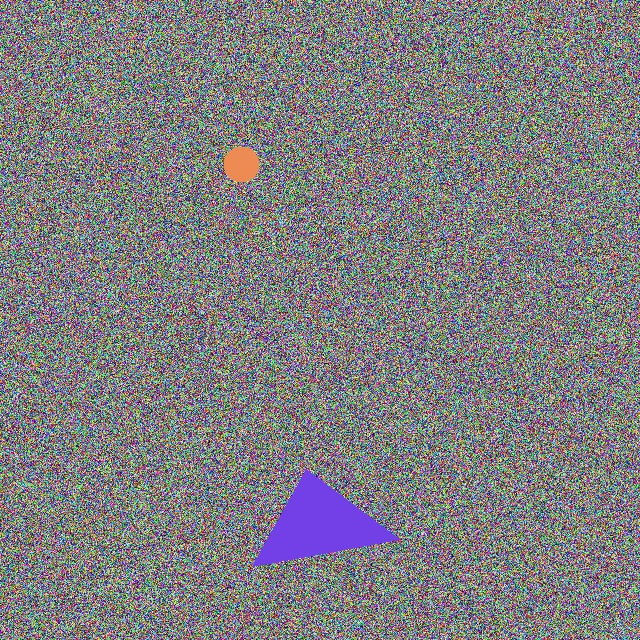

0 0.3765625 0.25625 0.05625 0.05625
1 0.50859375 0.80859375 0.2296875 0.1515625

In [10]:
val_images_dir = 'datasets/val/images/'
val_anno_dir   = 'datasets/val/labels/'

images = [f"{val_images_dir}{image}" for image in os.listdir(val_images_dir)]
labels = [f"{val_anno_dir}{label}" for label in os.listdir(val_anno_dir)]
images.sort()
labels.sort()

# Display the image
display(Image(images[0]))

# Display the annotations
Code(filename=labels[0], language='console')

# Train the Model

In [11]:
def create_config_file(config_file):
    """Creates and writes a YOLO config file necessary for training. 

    Args:
        config_file (str): The filename.'.
    """

    if not os.path.exists(config_file):
        f = open(config_file, "x")
        f.write('''\
# Train and test folders
train: 'train'
val: 'test'

# Number of classes
nc: 2
names: ['circle', 'triangle']''')
        f.close()

config_file = 'object_v12.yaml'
create_config_file(config_file)

In [12]:
# Initialize the YOLO model and print out the supported classes
YOLO_MODEL = 'yolo12n'
model = YOLO('{}.pt'.format(YOLO_MODEL))

print(model.names.values())

dict_values(['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'])


In [13]:
# Start the training
_ = model.train(
    data = config_file,
    imgsz = 640,
    epochs = 50,
    batch = 32,
    #device='cpu',
    name = YOLO_MODEL
)

New https://pypi.org/project/ultralytics/8.3.119 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.94 🚀 Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11169MiB)
engine/trainer: task=detect, mode=train, model=yolo12n.pt, data=object_v12.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo12n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fram

E0000 00:00:1745850104.130878    1107 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745850104.135503    1107 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    180864  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytics

train: Scanning /home/brian/Desktop/code/Demos/yolo/datasets/train/labels... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<00:00, 775.44it/s]


train: New cache created: /home/brian/Desktop/code/Demos/yolo/datasets/train/labels.cache


val: Scanning /home/brian/Desktop/code/Demos/yolo/datasets/test/labels... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<00:00, 1656.34it/s]

val: New cache created: /home/brian/Desktop/code/Demos/yolo/datasets/test/labels.cache


Plotting labels to runs/detect/yolo12n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolo12n
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.23G     0.8811      3.598      1.099         63        640: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         25         50    0.00427       0.64     0.0258     0.0216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/50      6.23G     0.9416        3.6      1.126         90        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

                   all         25         50    0.00478       0.72       0.11     0.0673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.23G      0.783      3.076     0.9992         67        640: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         25         50    0.00657       0.98       0.65      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.23G     0.7655      2.006      1.011         66        640: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]

                   all         25         50    0.00643       0.94       0.85      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.23G     0.7072      1.287      1.003         82        640: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         25         50    0.00622       0.92      0.844      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.23G     0.6545      1.159     0.9835         79        640: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         25         50     0.0059       0.88      0.825      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.23G     0.5981     0.9444     0.9312         71        640: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         25         50    0.00623       0.86        0.4       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.23G     0.5995      1.009     0.9576         61        640: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

                   all         25         50     0.0047       0.66     0.0386     0.0303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.23G     0.5971     0.9455     0.9228         58        640: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         25         50    0.00439       0.64      0.195      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.23G     0.6305     0.9516      0.962         61        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all         25         50          1     0.0835      0.374      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.23G     0.5817     0.8553     0.9247         62        640: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         25         50      0.754     0.0209      0.587      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.23G     0.5598     0.8433     0.9519         65        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

                   all         25         50    0.00612       0.86      0.774      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.23G     0.5771     0.8773     0.9456         50        640: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

                   all         25         50          1      0.196      0.781      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.23G      0.562     0.7775     0.9248         77        640: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]

                   all         25         50      0.877       0.36      0.788      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.23G     0.5301     0.7219     0.8993         65        640: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all         25         50       0.85        0.3      0.755      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.23G     0.5918     0.7843     0.9449         61        640: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         25         50      0.891      0.289      0.787      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.23G     0.5548     0.7467     0.9321         71        640: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

                   all         25         50      0.984       0.28       0.81       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.23G     0.5007     0.7191     0.9158         72        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         25         50      0.968      0.522      0.841      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.23G     0.5396     0.7276     0.9199         62        640: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]

                   all         25         50      0.959      0.817      0.905      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.23G     0.5485     0.7103     0.9282         64        640: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         25         50      0.989      0.833      0.992      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.23G     0.5126     0.6506     0.9208         67        640: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         25         50      0.986      0.818      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.23G     0.5031      0.687     0.9061         64        640: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         25         50      0.983      0.865      0.995      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.23G     0.5038     0.6505     0.9108         56        640: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         25         50      0.981      0.976      0.995      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.23G      0.488     0.6062     0.8947         66        640: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         25         50      0.981          1      0.995       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.23G     0.4973      0.605     0.8953         59        640: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         25         50      0.978          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.23G     0.4981     0.6152     0.9067         78        640: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         25         50      0.983          1      0.995      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.23G     0.4943     0.5942     0.8954         66        640: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         25         50      0.986          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.23G     0.4845     0.5861     0.9006         59        640: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         25         50      0.962          1      0.994       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.23G     0.4423     0.5514     0.8804         88        640: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         25         50      0.985          1      0.995       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.23G     0.4491     0.5607     0.8796         65        640: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         25         50      0.986          1      0.995      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.23G     0.4337     0.5611     0.8819         72        640: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         25         50      0.985          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.23G     0.4149     0.5093     0.8711         80        640: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all         25         50       0.99          1      0.995      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.23G     0.4073     0.5109      0.889         71        640: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         25         50      0.987          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.23G     0.4266     0.4997     0.8743         63        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         25         50      0.988          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.23G     0.4089     0.4947     0.8843         64        640: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         25         50      0.991          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.23G     0.4119     0.5022     0.8845         66        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         25         50       0.99          1      0.995      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.23G     0.4043     0.5033     0.8775         81        640: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

                   all         25         50       0.99          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.23G      0.402      0.494     0.8804         58        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         25         50      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.23G     0.4063     0.4674     0.8863         69        640: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         25         50      0.998          1      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.23G     0.3812     0.4458     0.8717         76        640: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]

                   all         25         50      0.997          1      0.995       0.98


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.23G     0.2761     0.4365     0.8343         42        640: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         25         50      0.994          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.23G     0.2601     0.4468     0.8067         44        640: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         25         50      0.993          1      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.23G     0.2825     0.4406      0.829         42        640: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         25         50      0.995          1      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.23G     0.2633      0.421     0.8212         43        640: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         25         50      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.23G     0.2502     0.4044     0.8242         43        640: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]

                   all         25         50      0.996          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.23G     0.2344     0.3917     0.8093         44        640: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         25         50      0.996          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.23G     0.2406     0.3933     0.8047         44        640: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         25         50      0.996          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.23G     0.2335     0.3821     0.8106         43        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         25         50      0.996          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.23G      0.233     0.3744     0.8018         44        640: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         25         50      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.23G     0.2253      0.372     0.8076         44        640: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         25         50      0.997          1      0.995      0.991



50 epochs completed in 0.038 hours.
Optimizer stripped from runs/detect/yolo12n/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo12n/weights/best.pt, 5.5MB

Validating runs/detect/yolo12n/weights/best.pt...
Ultralytics 8.3.94 🚀 Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11169MiB)
YOLOv12n summary (fused): 159 layers, 2,557,118 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


                   all         25         50      0.997          1      0.995      0.991
                circle         25         25      0.998          1      0.995      0.987
              triangle         25         25      0.995          1      0.995      0.995
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/yolo12n


In [14]:
# Display the classes the model supports now
print(model.names)

{0: 'circle', 1: 'triangle'}


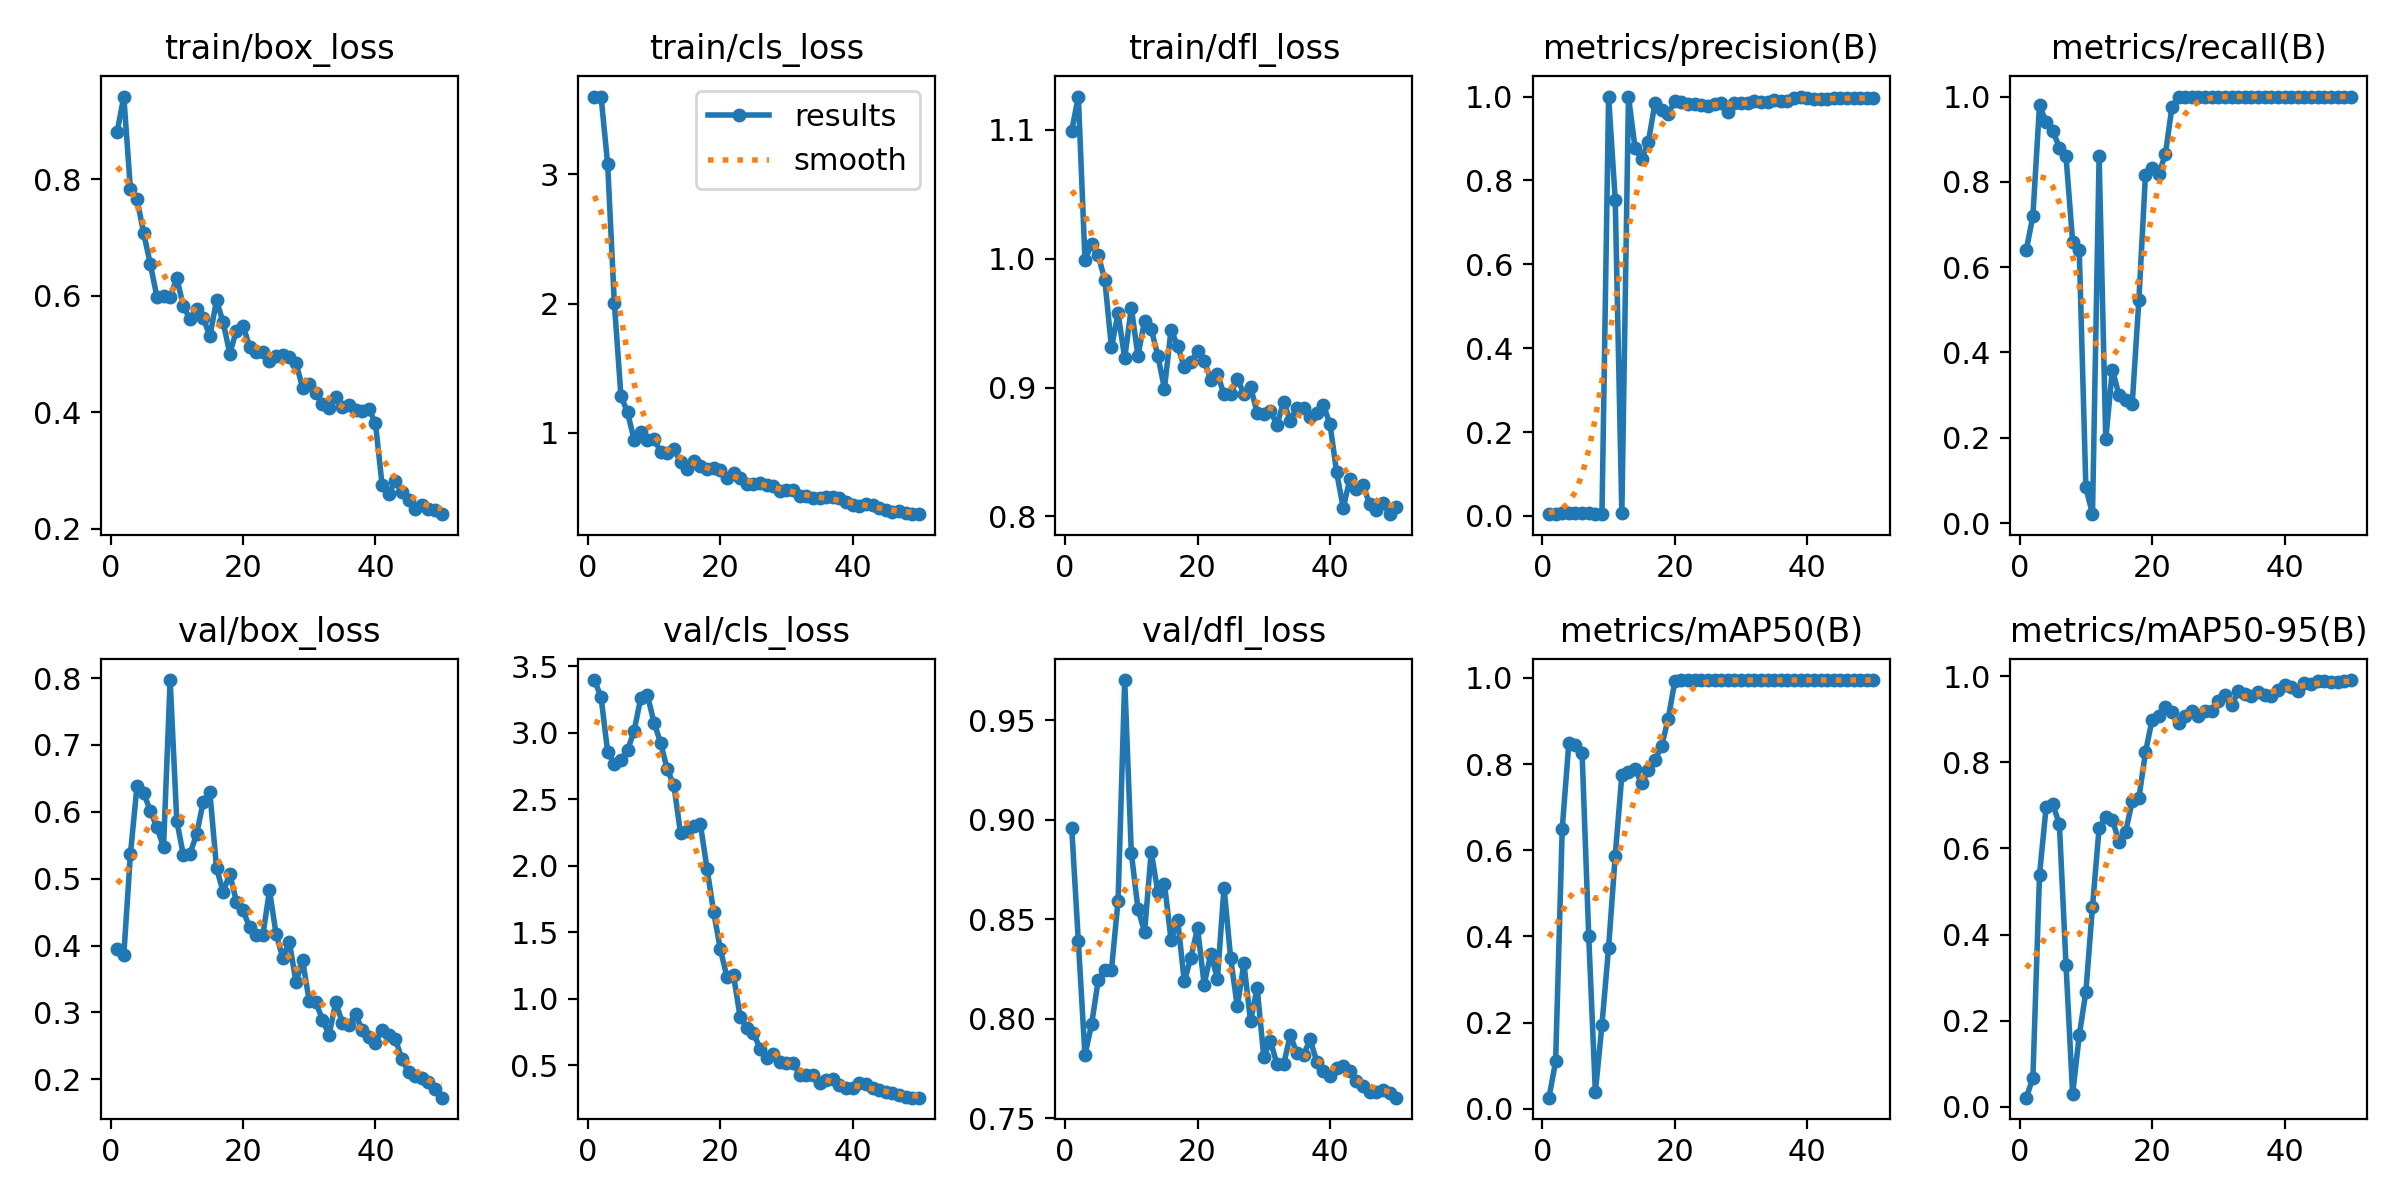

In [15]:
# Display the training characteristics
display(Image(f'runs/detect/{YOLO_MODEL}/results.png'))

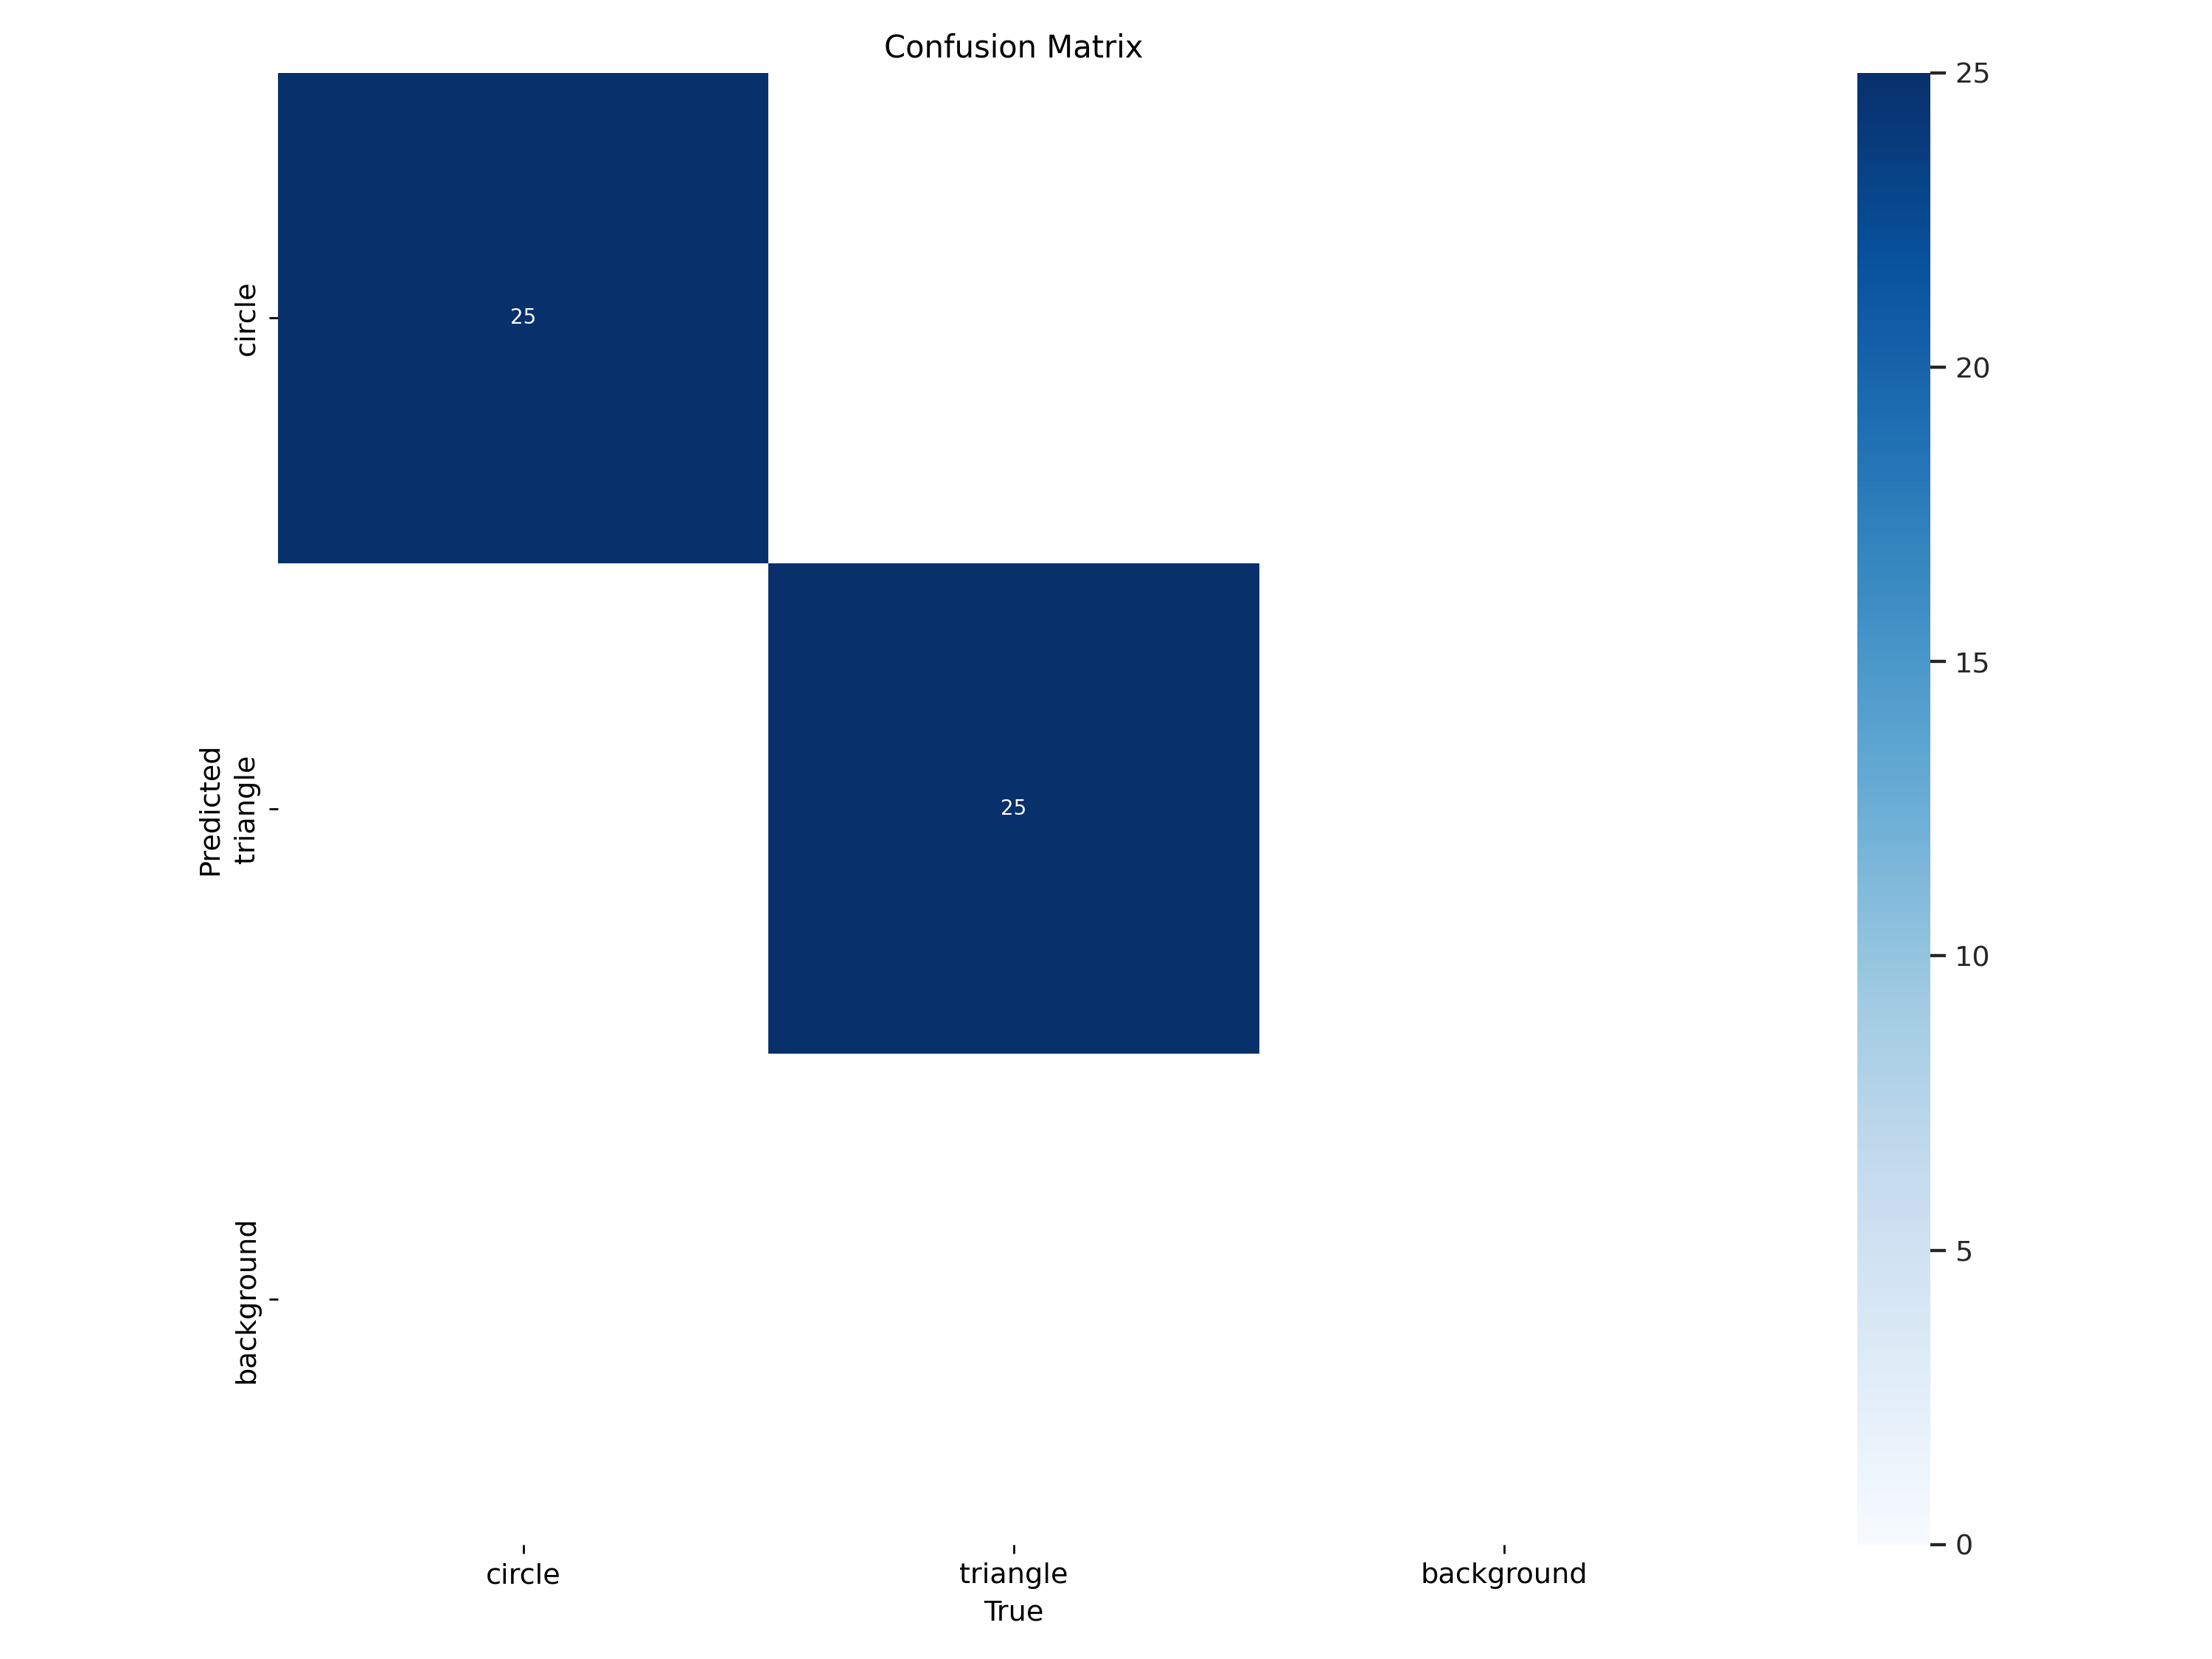

In [16]:
# Display the training characteristics
display(Image(f'runs/detect/{YOLO_MODEL}/confusion_matrix.png', width=1000, height=1000))

## Run YOLO

Let's annotate some of the model's output to see how it does.

In [17]:
# Load the best model
best_yolo_model = f'runs/detect/{YOLO_MODEL}/weights/best.pt'
model = YOLO(best_yolo_model)

# Load the paths to the validation images
val_images_dir = f'{DATA_DIR}/val/images/'
test_images = [f"{val_images_dir}{image}" for image in os.listdir(val_images_dir)]
batch_size = 64

# Create annotators for bounding box and labels
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_position=sv.Position.TOP_LEFT)

images = []

for i in range(0, len(test_images), batch_size):
    results = model.predict(test_images[i:i + batch_size])
    for result in results:
        detections = sv.Detections.from_ultralytics(result)
        img = cv2.imread(result.path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Annotate
        annotated_image = box_annotator.annotate(scene=img, detections=detections)
        annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

        images.append(annotated_image)


0: 640x640 1 circle, 1 triangle, 4.0ms
1: 640x640 1 circle, 1 triangle, 4.0ms
2: 640x640 1 circle, 1 triangle, 4.0ms
3: 640x640 1 circle, 1 triangle, 4.0ms
4: 640x640 1 circle, 1 triangle, 4.0ms
5: 640x640 1 circle, 1 triangle, 4.0ms
6: 640x640 1 circle, 1 triangle, 4.0ms
7: 640x640 1 circle, 1 triangle, 4.0ms
8: 640x640 1 circle, 1 triangle, 4.0ms
Speed: 1.6ms preprocess, 4.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


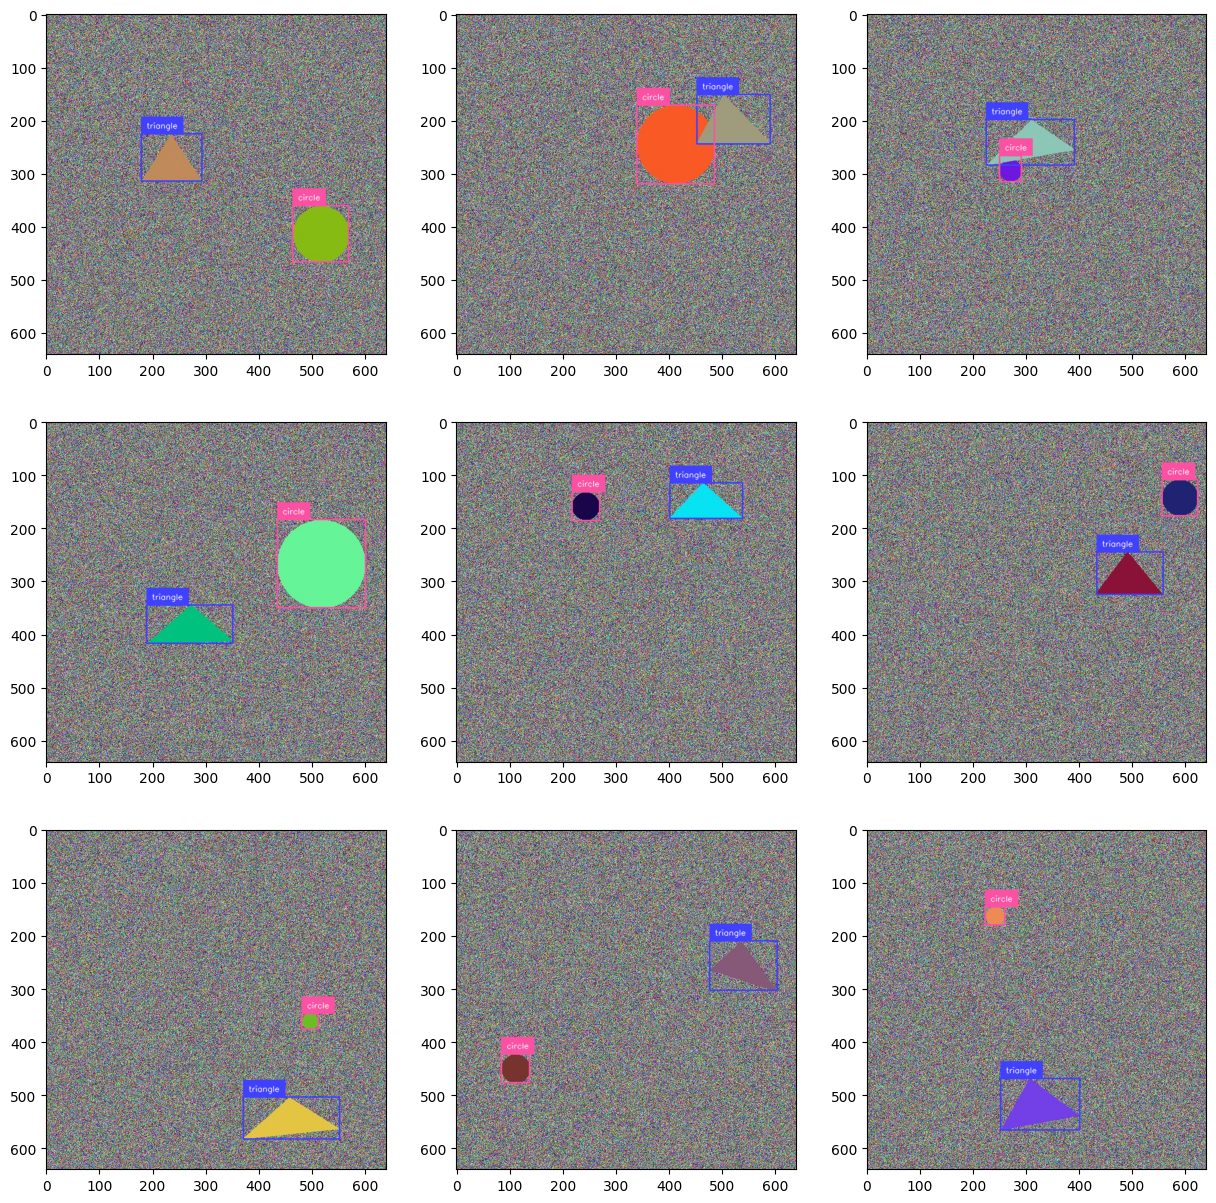

In [18]:
plt.figure(figsize=(15,15)) # specify the individual image size
#plt.figure(figsize=(15,15), dpi=1000) # specify the individual image size

for i in range(9):
    plt.subplot(3, 3, i+1)    
    plt.imshow(images[i])

plt.show()